## Q1 K-Means

Implement K-Means Clustering on the dataset at the following location :  https://archive.ics.uci.edu/ml/datasets/Facebook+Live+Sellers+in+Thailand

You are expected to do all necessary EDA, feature scaling and transforms.

First, arbitarily choose cluster value as 2. Then use the elbow method which was discussed in class to identify the best number of cluster. While exploring this, if you observe the need to consider inertia as a factor, do so with proper rationale.

Write a bried explanation as to how PCA can help with clustering in this example.

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime

In [259]:
data = pd.read_csv("https://raw.githubusercontent.com/gaurav639/ML_Plaksha_CSVs/main/Live_20210128.csv")

In [260]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   int64  
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(10), object(2)
memory

In [261]:
data.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,5,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


First we need to deal with status_published feature which is a timeseries feature. I converted this feature into datetime series then I took the time(hour component) and then group time into three categories:
1. hour >= 6 and hour < 12: Morning
2. hour >= 12 and hour < 18: Afternoon
3. other than this: Night 

In [242]:
# Convert the 'status_published' column to datetime
data['status_published'] = pd.to_datetime(data['status_published'])

# Extract the hour component
data['hour'] = data['status_published'].dt.hour

# Create a function to assign each hour to a class
def assign_class(hour):
  if hour >= 6 and hour < 12:
    return 'morning'
  elif hour >= 12 and hour < 18:
    return 'afternoon'
  else:
    return 'night'

# Apply the function to the 'hour' column
data['times_of_day'] = data['hour'].apply(assign_class)

Dropping all the columns which we don't need

In [243]:
data.drop(data.columns[[0, 2, 12, 13, 14, 15, 16]], axis=1, inplace=True)

In [244]:
data.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,times_of_day
0,video,529,512,262,432,92,3,1,1,0,morning
1,photo,150,0,0,150,0,0,0,0,0,night
2,video,227,236,57,204,21,1,1,0,0,morning
3,photo,111,0,0,111,0,0,0,0,0,night
4,photo,213,0,0,204,9,0,0,0,0,night


One-hot encoding 'status-type' and 'times_of_day' columns

In [245]:
data = pd.get_dummies(data, columns = ['status_type','times_of_day'])

In [246]:
data.columns

Index(['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves',
       'num_wows', 'num_hahas', 'num_sads', 'num_angrys', 'status_type_link',
       'status_type_photo', 'status_type_status', 'status_type_video',
       'times_of_day_afternoon', 'times_of_day_morning', 'times_of_day_night'],
      dtype='object')

Scaling all the features other than one-hot encoded features.

In [247]:
scaler = StandardScaler()
scaler.fit(data.iloc[:,:9])
data.iloc[:,:9] = scaler.transform(data.iloc[:,:9])

In [248]:
data.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video,times_of_day_afternoon,times_of_day_morning,times_of_day_night
0,0.646104,0.323350,1.686879,0.482727,1.983266,0.196196,0.076713,0.473570,-0.155748,0,0,0,1,0,1,0
1,-0.173192,-0.252206,-0.304144,-0.144720,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,0,1,0,0,0,0,1
2,-0.006738,0.013089,0.129017,-0.024571,0.206938,-0.033187,0.076713,-0.152587,-0.155748,0,0,0,1,0,1,0
3,-0.257499,-0.252206,-0.304144,-0.231495,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,0,1,0,0,0,0,1
4,-0.037003,-0.252206,-0.304144,-0.024571,-0.093286,-0.147879,-0.176010,-0.152587,-0.155748,0,1,0,0,0,0,1


Taking number of clusters = 2

In [191]:
# km0 = KMeans(n_clusters=2)
# data['cluster'] = km0.fit_predict(data)

**Inertia** is the sum of squared distances of samples to their closest cluster centre. We calculate it for every cluster in a particular range then plot it against number of clusters to see a dip in the line and then choose the number of clusters to take. 

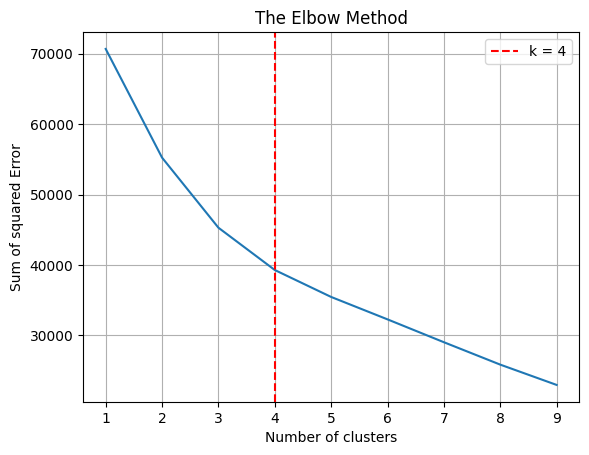

In [249]:
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k, max_iter=100, n_init=10, random_state=42)
    km.fit(data)
    sse.append(km.inertia_)

k = [i*100 for i in np.diff(sse,2)].index(min([i*100 for i 
     in np.diff(sse,2)]))

## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(sse)+1), sse)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Sum of squared Error")
ax.legend()
ax.grid(True)
plt.show()

From elbow method it is clear that we have to take number of clusters = 4, but when I am taking number of clusters = 3 then I am getting a very good separation. So, only by seeing elbow method we should not take the number of clusters, we take numbers around it also and check which number is giving better separation. In my case it is 3.

In [250]:
km = KMeans(n_clusters=3)
data['clusters'] = km.fit_predict(data)

In [251]:
label_center_dict = {k:v for k, v in zip(km.labels_, km.cluster_centers_)}
data['centroids'] = km.labels_
data['centroids'].replace(label_center_dict, inplace = True)

In [198]:
data.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video,times_of_day_afternoon,times_of_day_morning,times_of_day_night,clusters,centroids
0,0.646104,0.323350,1.686879,0.482727,1.983266,0.196196,0.076713,0.473570,-0.155748,-0.094957,-1.245993,-0.233666,1.421466,-0.161405,1.240816,-1.177194,0,-0.302706
1,-0.173192,-0.252206,-0.304144,-0.144720,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,-0.161405,-0.805921,0.849477,1,-0.101924
2,-0.006738,0.013089,0.129017,-0.024571,0.206938,-0.033187,0.076713,-0.152587,-0.155748,-0.094957,-1.245993,-0.233666,1.421466,-0.161405,1.240816,-1.177194,0,-0.292998
3,-0.257499,-0.252206,-0.304144,-0.231495,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,-0.161405,-0.805921,0.849477,1,-0.017871
4,-0.037003,-0.252206,-0.304144,-0.024571,-0.093286,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,-0.161405,-0.805921,0.849477,1,-0.207198


Here, I am using PCA to transform data to 2 dimensions for visualization. We can also use PCA in the start to first reduce the features then make the clusters. Since PCA is a technique that reduces the number of variables by combining them into bigger, more meaningful features.

So here, using PCA we can visually separate almost the entire data set.

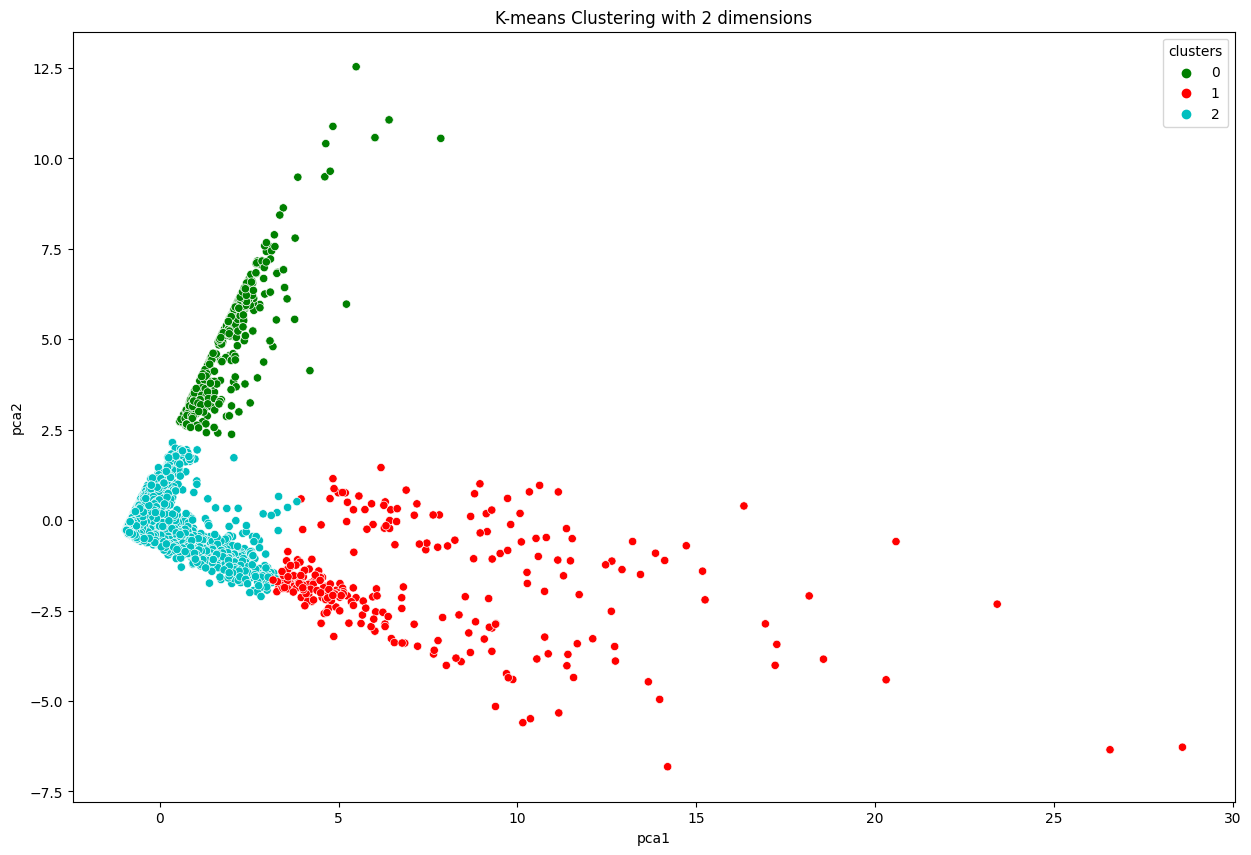

In [255]:
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(data)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x="pca1", y="pca2", hue=data['clusters'], data=results, palette = ['g','r','c'])
plt.title('K-means Clustering with 2 dimensions')

plt.show()

## Q2 Loss Functions

Let the desired output to 10 inputs be,

> [0,1,0,0,1,0,0,1,1,1]


and let the corresponding actual output obtained from a machine be 


> [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]


Find programmatically or by hand the loss obtained from using:

1.   a symmetric 0 − 1 loss function,

2.   the cross-entropy loss function and

3.   the hinge loss function.

If required assume a threshold of 0.5 to obtain a class from the machine output.  (sklearn by default uses 0.5 as threshold for binary classification) 

In [262]:
actual=[0,1,0,0,1,0,0,1,1,1]
pred=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

**1. Symmetric 0-1 Loss Function**

If actual value is equal to predicted value then that prediction is not penalised, else 1 is added to the loss. Hence the loss sum is divided by total number of points.

Reference: https://en.wikipedia.org/wiki/Loss_function#0-1_loss_function

In [268]:
predict=[]
x=0
for i in range(len(actual)):
  if pred[i]>0.5:
    predict.append(1)
  else:
    predict.append(0)
  if predict[i]==actual[i]:
    x+=0
  else:
    x+=1
print("The symmetric 0-1 loss using threshold 0.5 is {:.2f}".format(x/len(actual)))


The symmetric 0-1 loss using threshold 0.5 is 0.50


**2. Cross - Entropy Loss Function**

$ l = −y*log(p) - (1−y)*log(1−p)$ 

loss = sum(l) / (number of points)

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html

In [270]:
from sklearn.metrics import log_loss

print("The Cross-entropy loss using threshold 0.5 is {:.2f}".format(log_loss(actual,pred)))

The Cross-entropy loss using threshold 0.5 is 0.92


**3. Hinge Loss Function**

$l = max(0, 1-(actual*predicted))$ 

loss = sum(l) / (number of points)

Reference: https://en.wikipedia.org/wiki/Hinge_loss

In [269]:
x=0
for i in range(len(pred)):
    x+=max(0,1-actual[i]*pred[i])

print("The hinge loss using threshold 0.5 is {:.2f}".format(x/len(actual)))

The hinge loss using threshold 0.5 is 0.90
